In [159]:
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from sklearn.model_selection import train_test_split
import matplotlib
matplotlib.rcParams["figure.figsize"] = (6, 4)
plt.style.use("ggplot")
import tensorflow as tf
from tensorflow import data
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import mae
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, classification_report
import os

In [160]:
device = tf.config.list_physical_devices("GPU") if tf.config.list_physical_devices("GPU") else tf.config.list_physical_devices("CPU")
device

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [161]:
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/ptbdb_abnormal.csv
data/mitbih_test.csv
data/mitbih_train.csv
data/ptbdb_normal.csv


In [162]:
df_normal = pd.read_csv("data/ptbdb_normal.csv").iloc[:,:-1]
df_abnormal = pd.read_csv("data/ptbdb_abnormal.csv").iloc[:,:-1]

In [163]:
df_normal.head()

,1.000000000000000000e+00,9.003241658210754395e-01,3.585899472236633301e-01,5.145867168903350830e-02,4.659643396735191345e-02,1.268233358860015869e-01,1.333063244819641113e-01,1.191247999668121338e-01,1.106158867478370667e-01,1.130470037460327148e-01,...,0.000000000000000000e+00.55,0.000000000000000000e+00.56,0.000000000000000000e+00.57,0.000000000000000000e+00.58,0.000000000000000000e+00.59,0.000000000000000000e+00.60,0.000000000000000000e+00.61,0.000000000000000000e+00.62,0.000000000000000000e+00.63,0.000000000000000000e+00.64
0,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.948983,0.505265,0.004176,0.022513,0.059550,0.107298,0.110385,0.111293,0.116558,0.118192,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [164]:
print("Shape of Normal data", df_normal.shape)
print("Shape of Abnormal data", df_abnormal.shape)

Shape of Normal data (4045, 187)
Shape of Abnormal data (10505, 187)


In [165]:
def plot_sample(normal, anomaly):
    index = np.random.randint(0, len(normal), 2)

    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
    ax[0].plot(normal.iloc[index[0], :].values, label=f"Case {index[0]}")
    ax[0].plot(normal.iloc[index[1], :].values, label=f"Case {index[1]}")
    ax[0].legend(shadow=True, frameon=True, facecolor="inherit", loc=1, fontsize=9)
    ax[0].set_title("Normal")

    ax[1].plot(anomaly.iloc[index[0], :].values, label=f"Case {index[0]}")
    ax[1].plot(anomaly.iloc[index[1], :].values, label=f"Case {index[1]}")
    ax[1].legend(shadow=True, frameon=True, facecolor="inherit", loc=1, fontsize=9)
    ax[1].set_title("Anomaly")

    plt.tight_layout()
    plt.show()

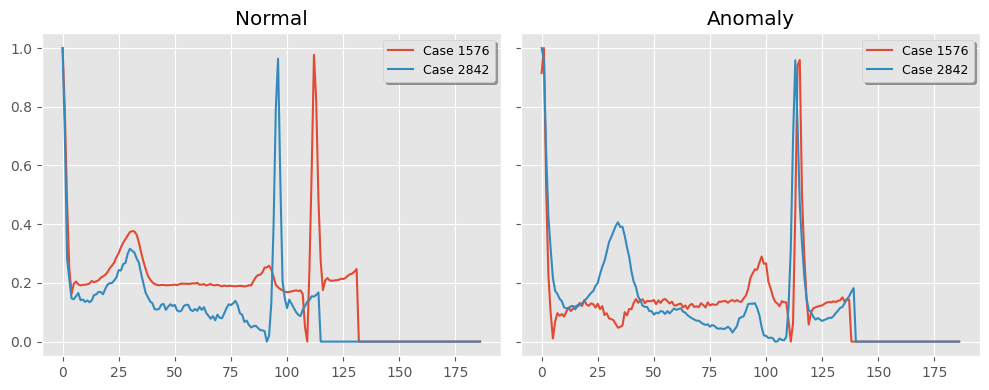

In [166]:
plot_sample(df_normal, df_abnormal)

In [167]:
CLASS_NAMES = ["Normal", "Abnormal"]
df_normal_copy = df_normal.copy()
df_abnormal_copy = df_abnormal.copy()

In [168]:
df_normal_copy = df_normal_copy.set_axis(range(1, 188), axis=1)
df_abnormal_copy = df_abnormal_copy.set_axis(range(1, 188), axis=1)
df_normal_copy = df_normal_copy.assign(target = CLASS_NAMES[0])
df_abnormal_copy = df_abnormal_copy.assign(target = CLASS_NAMES[1])


df = pd.concat((df_normal_copy, df_abnormal_copy))

In [169]:
def plot_smoothed_mean(data, class_name = "normal", step_size=5, ax=None):
    df = pd.DataFrame(data)
    roll_df = df.rolling(step_size)
    smoothed_mean = roll_df.mean().dropna().reset_index(drop=True)
    smoothed_std = roll_df.std().dropna().reset_index(drop=True)
    margin = 3*smoothed_std
    lower_bound = (smoothed_mean - margin).values.flatten()
    upper_bound = (smoothed_mean + margin).values.flatten()

    ax.plot(smoothed_mean.index, smoothed_mean)
    ax.fill_between(smoothed_mean.index, lower_bound, y2=upper_bound, alpha=0.3, color="red")
    ax.set_title(class_name, fontsize=9)

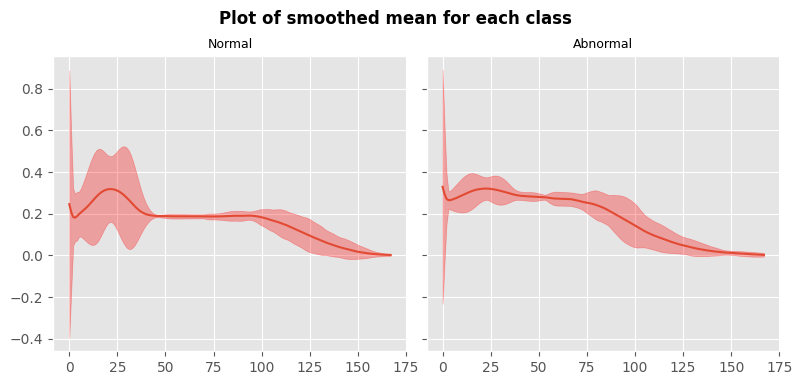

In [170]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
axes = axes.flatten()
for i, label in enumerate(CLASS_NAMES, start=1):
    data_group = df.groupby("target")
    data = data_group.get_group(label).mean(axis=0, numeric_only=True).to_numpy()
    plot_smoothed_mean(data, class_name=label, step_size=20, ax=axes[i-1])
fig.suptitle("Plot of smoothed mean for each class", y=0.95, weight="bold")
plt.tight_layout()

In [171]:
df_normal.drop("target", axis=1, errors="ignore", inplace=True)
normal = df_normal.to_numpy()
df_abnormal.drop("target", axis=1, errors="ignore", inplace=True)
abnormal = df_abnormal.to_numpy()

X_train, X_test = train_test_split(normal, test_size=0.15, random_state=45, shuffle=True)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}, anomaly shape: {abnormal.shape}")

Train shape: (3438, 187), Test shape: (607, 187), anomaly shape: (10505, 187)


In [172]:
tf.keras.utils.set_random_seed(1024)

In [352]:
class AutoEncoder(Model):
    def __init__(self, input_dim, latent_dim):
        super(AutoEncoder, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Reshape((input_dim, 1)),  # Reshape to 3D for Conv1D

            layers.Conv1D(128, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),

            layers.Conv1D(128, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),

            layers.Conv1D(128, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),

            layers.Conv1D(latent_dim, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
        ])
        self.decoder = tf.keras.Sequential([
            layers.Conv1DTranspose(latent_dim, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),

            layers.Conv1DTranspose(128, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),

            layers.Conv1DTranspose(128, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),

            layers.Conv1DTranspose(128, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),

            layers.Flatten(),
            layers.Dense(input_dim)
        ])

    def call(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded


input_dim = X_train.shape[-1]
latent_dim = 32

model = AutoEncoder(input_dim, latent_dim)
model.build((None, input_dim))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mae")
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'auto_encoder_34', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "auto_encoder_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_68 (Sequential)           │ (None, 12, 32)              │         113,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_69 (Sequential)           │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 113,056 (441.62 KB)

 Trainable params: 112,224 (438.38 KB)

 Non-trainable params: 832 (3.25 KB)

In [353]:
epochs = 100
batch_size = 128
early_stopping = EarlyStopping(patience=10, min_delta=1e-3, monitor="val_loss", restore_best_weights=True)


history = model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.1, callbacks=[early_stopping])

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - loss: 0.1165 - val_loss: 0.0640
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0582 - val_loss: 0.0489
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0468 - val_loss: 0.0422
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0412 - val_loss: 0.0407
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0384 - val_loss: 0.0369
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0355 - val_loss: 0.0347
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0339 - val_loss: 0.0345
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0328 - val_loss: 0.0323
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0316 - val_loss: 0.0316
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0304 - val_loss: 0.0314
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0296 - val_loss: 0.0295
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - los

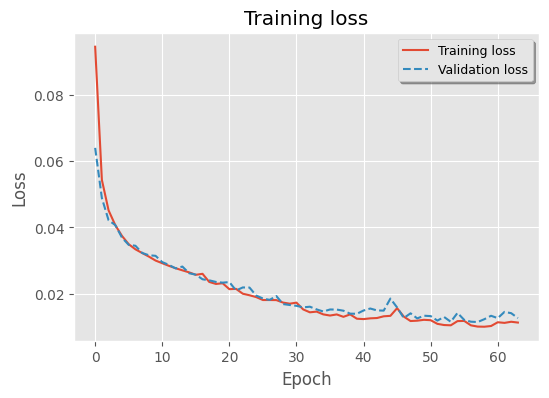

In [354]:
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss", ls="--")
plt.legend(shadow=True, frameon=True, facecolor="inherit", loc="best", fontsize=9)
plt.title("Training loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [355]:
train_mae = model.evaluate(X_train, X_train, verbose=0)
test_mae = model.evaluate(X_test, X_test, verbose=0)
abnormal_mae = model.evaluate(df_abnormal, df_abnormal, verbose=0)

print("Training dataset error: ", train_mae)
print("Testing dataset error: ", test_mae)
print("Anormaly dataset error: ", abnormal_mae)

Training dataset error:  0.010498515330255032
Testing dataset error:  0.011471578851342201
Anormaly dataset error:  0.029060188680887222


In [356]:
def predict(model, X):
    pred = model.predict(X, verbose=False)
    loss = mae(pred, X)
    return pred, loss

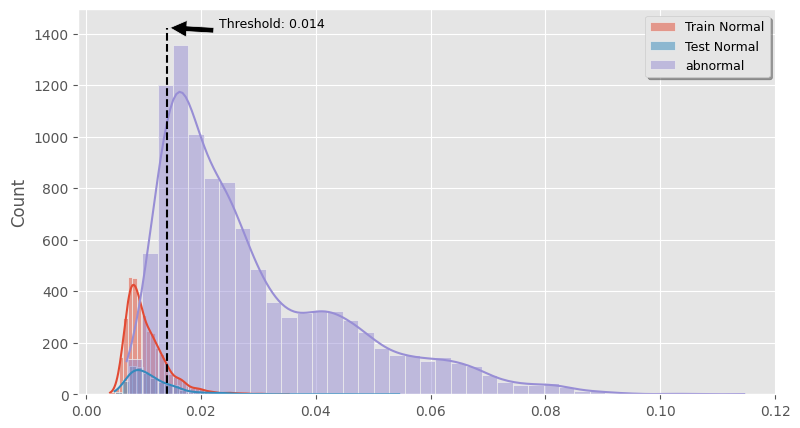

In [357]:
_, train_loss = predict(model, X_train)
_, test_loss = predict(model, X_test)
_, abnormal_loss = predict(model, abnormal)
threshold = np.mean(train_loss) + np.std(train_loss) # Setting threshold for distinguish normal data from anomalous data

bins = 40
plt.figure(figsize=(9, 5), dpi=100)
sns.histplot(np.clip(train_loss, 0, 0.5), bins=bins, kde=True, label="Train Normal")
sns.histplot(np.clip(test_loss, 0, 0.5), bins=bins, kde=True, label="Test Normal")
sns.histplot(np.clip(abnormal_loss, 0, 0.5), bins=bins, kde=True, label="abnormal")

ax = plt.gca()  # Get the current Axes
ylim = ax.get_ylim()
plt.vlines(threshold, 0, ylim[-1], color="k", ls="--")
plt.annotate(f"Threshold: {threshold:.3f}", xy=(threshold, ylim[-1]), xytext=(threshold+0.009, ylim[-1]),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=9)
plt.legend(shadow=True, frameon=True, facecolor="inherit", loc="best", fontsize=9)
plt.show()

In [358]:
def plot_examples(model, data, ax, title):
    pred, loss = predict(model, data)
    ax.plot(data.flatten(), label="Actual")
    ax.plot(pred[0], label = "Predicted")
    ax.fill_between(range(1, 188), data.flatten(), pred[0], alpha=0.3, color="r")
    ax.legend(shadow=True, frameon=True,
              facecolor="inherit", loc=1, fontsize=7)
#                bbox_to_anchor = (0, 0, 0.8, 0.25))

    ax.set_title(f"{title} (loss: {loss[0]:.3f})", fontsize=9.5)

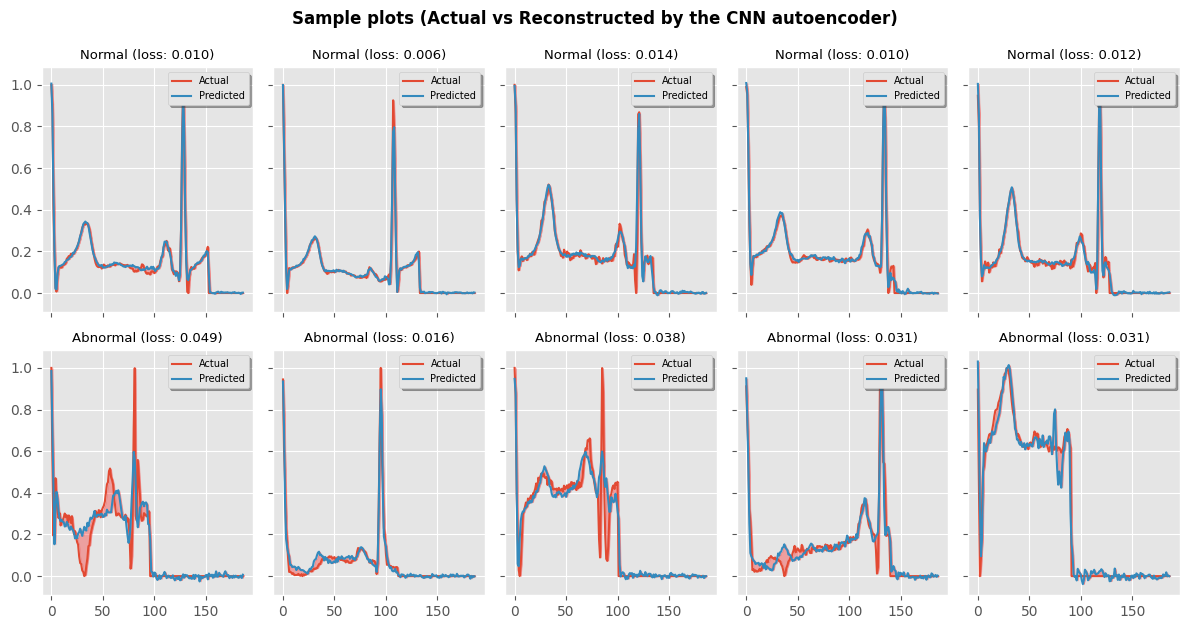

In [359]:
fig, axes = plt.subplots(2, 5, sharey=True, sharex=True, figsize=(12, 6), facecolor="w")
random_indexes = np.random.randint(0, len(X_train), size=5)

for i, idx in enumerate(random_indexes):
    data = X_train[[idx]]
    plot_examples(model, data, ax=axes[0, i], title="Normal")

for i, idx in enumerate(random_indexes):
    data = abnormal[[idx]]
    plot_examples(model, data, ax=axes[1, i], title="Abnormal")

plt.tight_layout()
fig.suptitle("Sample plots (Actual vs Reconstructed by the CNN autoencoder)", y=1.04, weight="bold")
fig.savefig("autoencoder.png", dpi=500)
plt.show()

In [360]:
fig.savefig("autoencoder.png", dpi=500, transparent=False, facecolor="white")

In [361]:
def evaluate_model(model, data):
    pred, loss = predict(model, data)
    if id(data) == id(abnormal):
        accuracy = np.sum(loss > threshold)/len(data)
    else:
        accuracy = np.sum(loss <= threshold)/len(data)
    return f"Accuracy: {accuracy:.2%}"

In [362]:
print("Training", evaluate_model(model, X_train))
print("Testing", evaluate_model(model, X_test))
print("Abnormal", evaluate_model(model, abnormal))

Training Accuracy: 86.91%
Testing Accuracy: 80.23%
Abnormal Accuracy: 86.83%


In [363]:
def prepare_labels(model, train, test, abnormal, threshold=threshold):
    ytrue = np.concatenate((np.ones(len(X_train)+len(X_test), dtype=int), np.zeros(len(abnormal), dtype=int)))
    _, train_loss = predict(model, train)
    _, test_loss = predict(model, test)
    _, abnormal_loss = predict(model, abnormal)
    train_pred = (train_loss <= threshold).numpy().astype(int)
    test_pred = (test_loss <= threshold).numpy().astype(int)
    abnormal_pred = (abnormal_loss < threshold).numpy().astype(int)
    ypred = np.concatenate((train_pred, test_pred, abnormal_pred))

    return ytrue, ypred

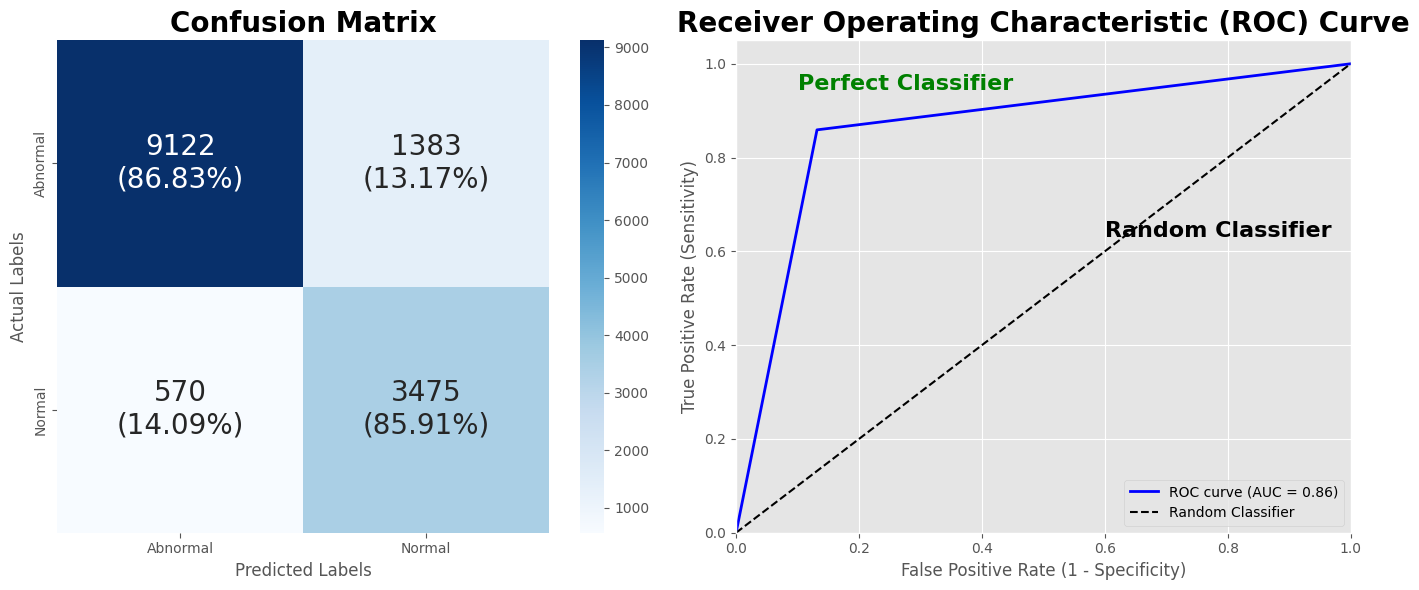

In [364]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    roc_auc_score
)

def plot_confusion_matrix_and_roc_curve(model, train, test, abnormal, threshold=0.5):
    # Prepare the labels and predictions
    ytrue, ypred = prepare_labels(model, train, test, abnormal, threshold=threshold)

    # Calculate accuracy, precision, recall, and f1 score
    accuracy = accuracy_score(ytrue, ypred)
    precision = precision_score(ytrue, ypred)
    recall = recall_score(ytrue, ypred)
    f1 = f1_score(ytrue, ypred)

    # Confusion matrix
    cm = confusion_matrix(ytrue, ypred)
    cm_norm = confusion_matrix(ytrue, ypred, normalize="true")
    data = np.array([f"{count}\n({pct:.2%})" for count, pct in zip(cm.ravel(), cm_norm.ravel())]).reshape(cm.shape)
    labels = ["Abnormal", "Normal"]

    # Plot confusion matrix
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    sns.heatmap(cm, annot=data, fmt="", xticklabels=labels, yticklabels=labels, cmap='Blues', ax=ax[0], annot_kws={"size": 20})
    ax[0].set_ylabel("Actual Labels")
    ax[0].set_xlabel("Predicted Labels")
    ax[0].set_title("Confusion Matrix", weight="bold", size=20)

    fpr, tpr, thresholds = roc_curve(ytrue, ypred)

    auc = roc_auc_score(ytrue, ypred)

    # Plot ROC curve
    ax[1].plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})', color='blue', linewidth=2)
    ax[1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('False Positive Rate (1 - Specificity)')
    ax[1].set_ylabel('True Positive Rate (Sensitivity)')
    ax[1].set_title('Receiver Operating Characteristic (ROC) Curve', weight="bold", size=20)
    ax[1].legend(loc="lower right")

    ax[1].annotate('Perfect Classifier', xy=(0, 1), xytext=(0.1, 0.9), textcoords='axes fraction',
                   fontsize=16, color='green', weight='bold')
    ax[1].annotate('Random Classifier', xy=(0.5, 0.5), xytext=(0.6, 0.6), textcoords='axes fraction',
                   fontsize=16, color='black', weight='bold')

    plt.tight_layout()
    fig.savefig("Results.png")
    plt.show()


plot_confusion_matrix_and_roc_curve(model, X_train, X_test, abnormal, threshold=threshold)

In [365]:
ytrue, ypred = prepare_labels(model, X_train, X_test, abnormal, threshold=threshold)
print(classification_report(ytrue, ypred, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

      Normal       0.94      0.87      0.90     10505
    Abnormal       0.72      0.86      0.78      4045

    accuracy                           0.87     14550
   macro avg       0.83      0.86      0.84     14550
weighted avg       0.88      0.87      0.87     14550

